In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
from torch.utils.data.dataloader import DataLoader
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import networkx as nx
from tqdm import tqdm
import dgl
import morphsim as m
from graphenvs import HalfCheetahGraphEnv
import itertools

Running on the GPU


Using backend: pytorch


In [2]:
class Network(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        batch_size=256, # Needed only for batch norm
        with_batch_norm=False,
        activation=None
    ):
        super(Network, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
#             self.layers.append(nn.BatchNorm1d(batch_size))
            self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[0])))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
#                 self.layers.append(nn.BatchNorm1d(batch_size))
                self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[i+1])))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
        if activation is not None:
            self.layers.append(activation())
            
    def forward(self, x):
        out = x
        
        for layer in self.layers:
            out = layer(out)
            
        return out

In [3]:
class GraphNeuralNetwork(nn.Module):
    def __init__(
        self,
        inputNetwork,
        messageNetwork,
        updateNetwork,
        outputNetwork,
        numMessagePassingIterations,
        encoder = True
    ):
        
        super(GraphNeuralNetwork, self).__init__()
                
        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork
        
        self.numMessagePassingIterations = numMessagePassingIterations
        self.encoder = encoder
        
    def inputFunction(self, nodes):
        return {'state' : self.inputNetwork(nodes.data['input'])}
    
    def messageFunction(self, edges):
        
        batchSize = edges.src['state'].shape[1]
        edgeData = edges.data['feature'].repeat(batchSize, 1).T.unsqueeze(-1)
        nodeInput = edges.src['input']
        
#         print(edges.src['state'].shape)
#         print(nodeInput.shape)
        return {'m' : self.messageNetwork(torch.cat((edges.src['state'], edgeData, nodeInput), -1))}
        

    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def outputFunction(self, nodes):
        
#         numNodes, batchSize, stateSize = graph.ndata['state'].shape
#         return self.outputNetwork.forward(graph.ndata['state'])
        return {'output': self.outputNetwork(nodes.data['state'])}


    def forward(self, graph, state):
        
        self.update_states_in_graph(graph, state)
        
        graph.apply_nodes(self.inputFunction)
        
        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.max('m', 'm_hat'), self.updateFunction)
        
        graph.apply_nodes(self.outputFunction)
        
        output = graph.ndata['output']
        
        return output
    
    def update_states_in_graph(self, graph, state):
        
        if self.encoder:
            if len(state.shape) == 1:
                state = state.unsqueeze(0)

            numGraphFeature = 6
            numGlobalStateInformation = 5
            numLocalStateInformation = 2
            numStateVar = state.shape[1]
            globalInformation = state[:, 0:5]
            batch_size = state.shape[0]
            numNodes = (numStateVar - 5) // 2

            nodeData = torch.empty((numNodes, batch_size, numGraphFeature + numGlobalStateInformation + numLocalStateInformation)).to(device)

            nodeData[:, :, 0:numGlobalStateInformation] = globalInformation            
            for nodeIdx in range(numNodes):
                # Assign local state information
                nodeData[nodeIdx, :, numGlobalStateInformation] = state[:, 5 + nodeIdx]
                nodeData[nodeIdx, :, numGlobalStateInformation + 1] = state[:, 5 + numNodes + nodeIdx]
                # Assign global features from graph
                nodeData[nodeIdx, :, numGlobalStateInformation + 2 : numGlobalStateInformation + 2 + numGraphFeature] = graph.ndata['feature'][nodeIdx]

            graph.ndata['input'] = nodeData
        
        else:
            numNodes, batchSize, inputSize = state.shape
            nodeData = torch.empty((numNodes, batchSize, inputSize + 6)).to(device)
            nodeData[:, :, :inputSize] = state
            nodeData[:, :, inputSize : inputSize + 6] = graph.ndata['feature'].unsqueeze(dim=1).repeat_interleave(batchSize, dim=1)
#             for nodeIdx in range(numNodes):
#                 nodeData[nodeIdx, :, inputSize : inputSize + 6] = graph.ndata['feature'][nodeIdx]
            
            graph.ndata['input'] = nodeData
        

In [4]:
states = {}
actions = {}
rewards = {}
next_states = {}
dones = {}
env = {}

for morphIdx in range(7):

    prefix = '../datasets/{}/'.format(morphIdx)
    
    states[morphIdx] = np.load(prefix + 'states_array.npy')
    actions[morphIdx] = np.load(prefix + 'actions_array.npy')
    rewards[morphIdx] = np.load(prefix + 'rewards_array.npy')
    next_states[morphIdx] = np.load(prefix + 'next_states_array.npy')
    dones[morphIdx] = np.load(prefix + 'dones_array.npy')
    
    env[morphIdx] = HalfCheetahGraphEnv(None)
    env[morphIdx].set_morphology(morphIdx)
    env[morphIdx].reset()

/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None
NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


NoneType: None
NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


NoneType: None
NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************
None
*************************************************************************************************************


NoneType: None


In [5]:
X_test = {}
X_train = {}
Y_test = {}
Y_train = {}

for morphIdx in range(7):
    X = states[morphIdx]
    Y = next_states[morphIdx]
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    X_test[morphIdx] = torch.from_numpy(X[:100000]).float()
    X_train[morphIdx] = torch.from_numpy(X[100000:]).float()
    Y = Y[permutation]
    Y_test[morphIdx] = torch.from_numpy(Y[:100000]).float()
    Y_train[morphIdx] = torch.from_numpy(Y[100000:]).float()

In [12]:
hidden_sizes = [256, 256]

inputSize = 13
stateSize = 64
messageSize = 64
latentSize = 4
numMessagePassingIterations = 6
batch_size = 1024
numBatchesPerTrainingStep = 1
minDistanceSeqAndRand = 0.25
with_batch_norm = True

# # Encoder Networks 
encoderInputNetwork = Network(inputSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderMessageNetwork = Network(stateSize + inputSize + 1, messageSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
encoderUpdateNetwork = Network(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderOutputNetwork = Network(stateSize, latentSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
encoderGNN = GraphNeuralNetwork(encoderInputNetwork, encoderMessageNetwork, encoderUpdateNetwork, encoderOutputNetwork, numMessagePassingIterations, encoder=True).to(device)

# # Decoder Networks
decoderInputNetwork = Network(latentSize + 6, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
decoderMessageNetwork = Network(stateSize + latentSize + 7, messageSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
decoderUpdateNetwork = Network(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
decoderOutputNetwork = Network(stateSize, 7, hidden_sizes, with_batch_norm=with_batch_norm)
decoderGNN = GraphNeuralNetwork(decoderInputNetwork, decoderMessageNetwork, decoderUpdateNetwork, decoderOutputNetwork, numMessagePassingIterations, encoder=False).to(device)

# Optimizer
lr =  1e-3
optimizer = optim.Adam(itertools.chain(
                    encoderInputNetwork.parameters(), encoderMessageNetwork.parameters(), 
                    encoderUpdateNetwork.parameters(), encoderOutputNetwork.parameters(),
                    decoderInputNetwork.parameters(), decoderMessageNetwork.parameters(), 
                    decoderUpdateNetwork.parameters(), decoderOutputNetwork.parameters()),
                    lr, weight_decay=0)

lr_lambda = lambda epoch: 0.7
lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda)
criterion  = nn.MSELoss(reduction='none')

In [13]:
numTrainingBatches = int(np.ceil(X_train[0].shape[0] / batch_size))
numTestingBatches = int(np.ceil(X_test[0].shape[0] / batch_size))


zeroTensor = torch.zeros([1]).to(device)
trainLosses = {}
testLosses = {}
validLosses = {}
trainingIdxs = [0,1,2,3,4,5,6]
validationIdxs = []

encoderInputNetworkGradients = []
encoderMessageNetworkGradients = []
encoderUpdateNetworkGradients = []
encoderOutputNetworkGradients = []
decoderInputNetworkGradients = []
decoderMessageNetworkGradients = []
decoderUpdateNetworkGradients = []
decoderOutputNetworkGradients = []

for morphIdx in range(7):
    trainLosses[morphIdx] = []
    testLosses[morphIdx] = []
    validLosses[morphIdx] = []

In [14]:
# encoderGNN.load_state_dict(torch.load('encoderGNN-normalized-time-contrastive.pt'))
# decoderGNN.load_state_dict(torch.load('decoderGNN-normalized-time-contrastive.pt'))

In [ ]:
for epoch in range(10):
    
    print('Starting Epoch {}'.format(epoch))
    epoch_t0 = time.time()
    
    for morphIdx in trainingIdxs:
        permutation = np.random.permutation(X_train[morphIdx].shape[0])
        X_train[morphIdx] = X_train[morphIdx][permutation]
        Y_train[morphIdx] = Y_train[morphIdx][permutation]
    
    with torch.no_grad():
        for morphIdx in trainingIdxs:
            testLosses[morphIdx].append(np.zeros(2))
            for batch_ in range(0, numTestingBatches-1):

                encoder_graph = env[morphIdx].get_graph()._get_dgl_graph()
                decoder_graph = env[morphIdx].get_graph()._get_dgl_graph()

                current_states = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size]
                next_states = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size]
                random_indexes = np.random.choice(X_train[0].shape[0],size=batch_size, replace=False)
                random_states = X_train[morphIdx][random_indexes]

                encoderInput = torch.cat((current_states, next_states, random_states), dim=0).to(device)

                latent_states = encoderGNN(encoder_graph, encoderInput)
                normalized_latent_states = latent_states / torch.sqrt(1e-8 + (latent_states ** 2).sum(dim=-1)).unsqueeze(2)
                current_state_reconstruction = decoderGNN(decoder_graph, normalized_latent_states[:, 0:current_states.shape[0], :])
                current_state_reconstruction[:, :, 0:5] = current_state_reconstruction[:, :, 0:5].mean(dim=0)

                autoencoder_loss = criterion(encoder_graph.ndata['input'][:, 0:batch_size, :7], current_state_reconstruction).mean()
                # Calculate 2-norm for positive/sequential samples over the data dimension - result is of dimension (nodes, batch_size)
                sequential_distances = torch.norm(normalized_latent_states[:, 0:batch_size, :] - normalized_latent_states[:, batch_size:batch_size * 2, :], p=None, dim=2)
                # Calculate 2-norm for negative/random samples over data dimension - result is of dimension (nodes, batch_size)
                random_distances = torch.norm(normalized_latent_states[:, 0:batch_size, :] - normalized_latent_states[:, 2 * batch_size: 3 * batch_size, :], p=None, dim=2)
                # Calculate contrastive loss for each entry - result is of dimension (nodes, batch_size)
                contrastive_loss = torch.max(zeroTensor, sequential_distances - random_distances + minDistanceSeqAndRand)
                # get 0-1 matrix which is True if entry is not 0
                mask = contrastive_loss != 0
                # Compute average over nonzero entries in batch, result will be scalar
                final_contrastive_loss = contrastive_loss.sum() / mask.sum()

    #                 contrastive_loss_1 = torch.max(torch.zeros(1).to(device), criterion(latent_states[:, 0:batch_size, :], latent_states[:, batch_size:batch_size * 2, :]).mean() - maxSequentialDistance).mean()
    #                 contrastive_loss_2 = torch.max(torch.zeros(1).to(device), minRandomDistance - criterion(latent_states[:, 0:batch_size, :], latent_states[:, 2 * batch_size: 3 * batch_size, :]).mean()).mean()

                testLosses[morphIdx][-1][0] += autoencoder_loss.item() / numBatchesPerTrainingStep
                testLosses[morphIdx][-1][1] += final_contrastive_loss.item() / numBatchesPerTrainingStep
            testLosses[morphIdx][-1] /= numTestingBatches-1

    for morphIdx in trainingIdxs:
        print('Idx {} | Test {} : {}'.format(
            morphIdx, np.round(testLosses[morphIdx][-1][0], decimals=3), np.round(testLosses[morphIdx][-1][1], decimals=3)))
    
    stepLoss = None

    for batch in range(0, numTrainingBatches-1, numBatchesPerTrainingStep):
                
        t0 = time.time()
        
        for morphIdx in trainingIdxs:
            numNodes = (X_train[morphIdx].shape[1] - 5) // 2
            trainLosses[morphIdx].append(np.zeros(2))
        
        
        for batchOffset in range(numBatchesPerTrainingStep):
                        
            if batch + batchOffset >= numTrainingBatches - 1:
                break
                
            for morphIdx in trainingIdxs:
                encoder_graph = env[morphIdx].get_graph()._get_dgl_graph()
                decoder_graph = env[morphIdx].get_graph()._get_dgl_graph()
                                
                current_states = X_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size]
                next_states = Y_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size]
                random_indexes = np.random.choice(X_train[0].shape[0],size=current_states.shape[0], replace=False)
                random_states = X_train[morphIdx][random_indexes]
                
                encoderInput = torch.cat((current_states, next_states, random_states), dim=0).to(device)
                latent_states = encoderGNN(encoder_graph, encoderInput)
                normalized_latent_states = latent_states / torch.sqrt(1e-8 + (latent_states ** 2).sum(dim=-1)).unsqueeze(2)
                
                current_state_reconstruction = decoderGNN(decoder_graph, normalized_latent_states[:, 0:current_states.shape[0], :])
                current_state_reconstruction[:, :, 0:5] = current_state_reconstruction[:, :, 0:5].mean(dim=0)
                autoencoder_loss = criterion(encoder_graph.ndata['input'][:, 0:batch_size, :7], current_state_reconstruction).mean()
                
                # Calculate 2-norm for positive/sequential samples over the data dimension - result is of dimension (nodes, batch_size)
                sequential_distances = torch.norm(normalized_latent_states[:, 0:batch_size, :] - normalized_latent_states[:, batch_size:batch_size * 2, :], p=None, dim=2)
                # Calculate 2-norm for negative/random samples over data dimension - result is of dimension (nodes, batch_size)
                random_distances = torch.norm(normalized_latent_states[:, 0:batch_size, :] - normalized_latent_states[:, 2 * batch_size: 3 * batch_size, :], p=None, dim=2)
                # Calculate contrastive loss for each entry - result is of dimension (nodes, batch_size)
                contrastive_loss = torch.max(zeroTensor, sequential_distances - random_distances + minDistanceSeqAndRand)
                # get 0-1 matrix which is True if entry is not 0
                mask = contrastive_loss != 0
                # Compute average over nonzero entries in batch, result will be scalar
                final_contrastive_loss = contrastive_loss.sum() / mask.sum()
                
                # contrastive_loss_1 = torch.max(torch.zeros(1).to(device), criterion(latent_states[:, 0:batch_size, :], latent_states[:, batch_size:batch_size * 2, :]).mean() - maxSequentialDistance).mean()
                # contrastive_loss_2 = torch.max(torch.zeros(1).to(device), minRandomDistance - criterion(latent_states[:, 0:batch_size, :], latent_states[:, 2 * batch_size: 3 * batch_size, :]).mean()).mean()
                
                trainLosses[morphIdx][-1][0] += autoencoder_loss.item() / numBatchesPerTrainingStep
                trainLosses[morphIdx][-1][1] += final_contrastive_loss.item() / numBatchesPerTrainingStep
            
                stepLoss = autoencoder_loss + final_contrastive_loss
                stepLoss /= (len(trainingIdxs) * numBatchesPerTrainingStep)
                stepLoss.backward()
                        
        
        if batch % 200 == 0:
            print('Batch {} in {}s'.format(batch, np.round(time.time() - t0, decimals=1)))
            for morphIdx in trainingIdxs:
                print('Idx {} | Train {} : {}'.format(
                    morphIdx, np.round(trainLosses[morphIdx][-1][0], decimals=3), 
                    np.round(trainLosses[morphIdx][-1][1], decimals=3)))

            
            s = 0
            for parameter in encoderInputNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            encoderInputNetworkGradients.append(s.item())

            s = 0
            for parameter in encoderMessageNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            encoderMessageNetworkGradients.append(s.item())

            s = 0
            for parameter in encoderUpdateNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            encoderUpdateNetworkGradients.append(s.item())

            s = 0
            for parameter in encoderOutputNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            encoderOutputNetworkGradients.append(s.item())

            s = 0
            for parameter in decoderInputNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            decoderInputNetworkGradients.append(s.item())

            s = 0
            for parameter in decoderMessageNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            decoderMessageNetworkGradients.append(s.item())

            s = 0
            for parameter in decoderUpdateNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            decoderUpdateNetworkGradients.append(s.item())

            s = 0
            for parameter in decoderOutputNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            decoderOutputNetworkGradients.append(s.item())

            print('Gradients: Encoder Input {} | Encoder Message {} | Encoder  Update {} | Encoder Output {}'.format(
                np.round(np.log10(encoderInputNetworkGradients[-1]), decimals=2), np.round(np.log10(encoderMessageNetworkGradients[-1]), decimals=2), np.round(np.log10(encoderUpdateNetworkGradients[-1]), decimals=2), np.round(np.log10(encoderOutputNetworkGradients[-1]), decimals=2)))    

            print('Gradients: Decoder Input {} | Decoder Message {} | Decoder  Update {} | Decoder Output {}'.format(
                np.round(np.log10(decoderInputNetworkGradients[-1]), decimals=2), np.round(np.log10(decoderMessageNetworkGradients[-1]), decimals=2), np.round(np.log10(decoderUpdateNetworkGradients[-1]), decimals=2), np.round(np.log10(decoderOutputNetworkGradients[-1]), decimals=2)))
            
            print()
            
        optimizer.step()        
        optimizer.zero_grad()
        
    # Dereference variables to release memory
    stepLoss = None
    encoder_graph = None
    decoder_graph = None
    encoderInput = None
    latent_states = None
    normalized_latent_states = None
    current_state_reconstruction = None
    autoencoder_loss = None
    contrastive_loss_1 = None
    contrastive_loss_2 = None
    torch.cuda.empty_cache()
        
        
    t_final = time.time() - t0

    print('Epoch {} finished in {}'.format(epoch, np.round(time.time() - epoch_t0, decimals=1)))
    lr_scheduler.step()
    
        

Starting Epoch 0
Idx 0 | Test 1.692 : 0.183
Idx 1 | Test 4.344 : 0.177
Idx 2 | Test 4.268 : 0.227
Idx 3 | Test 5.191 : 0.209
Idx 4 | Test 7.909 : 0.231
Idx 5 | Test 2.469 : 0.221
Idx 6 | Test 2.96 : 0.243
Batch 0 in 2.2s
Idx 0 | Train 1.655 : 0.183
Idx 1 | Train 4.353 : 0.176
Idx 2 | Train 4.349 : 0.23
Idx 3 | Train 5.226 : 0.209
Idx 4 | Train 7.937 : 0.229
Idx 5 | Train 2.463 : 0.221
Idx 6 | Train 3.005 : 0.243
Gradients: Encoder Input -2.29 | Encoder Message -1.27 | Encoder  Update -0.98 | Encoder Output -0.8
Gradients: Decoder Input -1.0 | Decoder Message -0.39 | Decoder  Update -0.21 | Decoder Output -0.22

Batch 200 in 2.3s
Idx 0 | Train 0.408 : 0.132
Idx 1 | Train 0.376 : 0.185
Idx 2 | Train 0.838 : 0.157
Idx 3 | Train 0.257 : 0.137
Idx 4 | Train 0.698 : 0.16
Idx 5 | Train 0.65 : 0.17
Idx 6 | Train 0.426 : 0.186
Gradients: Encoder Input -3.87 | Encoder Message -1.64 | Encoder  Update -1.54 | Encoder Output -0.55
Gradients: Decoder Input -3.54 | Decoder Message -1.31 | Decoder  Up

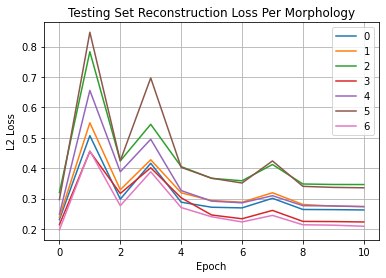

In [38]:
fig, ax = plt.subplots(1, sharex=True)
for morphIdx in trainingIdxs:
    lossArr = np.sum(np.array(testLosses[morphIdx]), 1)
    ax.plot(range(lossArr.shape[0]-1), lossArr[1:])
for morphIdx in validationIdxs:
    lossArr = np.sum(np.array(validLosses[morphIdx]), 1)
    ax.plot(range(lossArr.shape[0]), lossArr)

plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('L2 Loss')
plt.title('Testing Set Reconstruction Loss Per Morphology')
plt.legend(trainingIdxs + validationIdxs)
plt.savefig('time-contrastive-losses-alpha-0.25.jpg')
plt.show()

In [39]:
torch.save(encoderGNN.state_dict(), 'encoderGNN-normalized-time-contrastive-alpha-0.25.pt')
torch.save(decoderGNN.state_dict(), 'decoderGNN-normalized-time-contrastive-alpha-0.25.pt')

In [ ]:
with open('trainingParameters.txt', 'w') as file:
    file.write('hidden_sizes ' + str(hidden_sizes) + '\n')
    file.write('inputSize ' + str(inputSize) + '\n')
    file.write('stateSize ' + str(stateSize) + '\n')
    file.write('latentSize ' + str(latentSize) + '\n')
    file.write('numMessagePassingIterations ' + str(numMessagePassingIterations) + '\n')
    file.write('batch_size ' + str(batch_size) + '\n')
    file.write('numBatchesPerTrainingStep ' + str(numBatchesPerTrainingStep) + '\n')
    file.write('minRandomDistance ' + str(minRandomDistance) + '\n')
    file.write('maxSequentialDistance ' + str(maxSequentialDistance) + '\n')
    file.write('with_batch_norm ' + str(with_batch_norm) + '\n')